In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utility import load_dataset

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


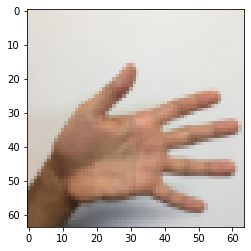

In [3]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Shapes Of data

In [4]:
print('X_train_orig shape : ',X_train_orig.shape)
print('Y_train_orig shape : ',Y_train_orig.shape)
print('X_test_orig  shape : ',X_test_orig.shape)
print('Y_test_orig  shape : ',Y_test_orig.shape)

X_train_orig shape :  (1080, 64, 64, 3)
Y_train_orig shape :  (1, 1080)
X_test_orig  shape :  (120, 64, 64, 3)
Y_test_orig  shape :  (1, 120)


In [5]:
#Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

In [6]:
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

In [7]:
m_train = X_train_orig.shape[0]
m_test  = X_test_orig.shape[0]
num_px  = X_train_orig.shape[1]

### For Multiclass Classification we convert the labels to One-Hot Matrix

In [8]:
def one_hot(C,labels):
    C  = tf.constant(C,name='C')
    one_hot_matrix = tf.one_hot(labels,C,axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [9]:
#example
labels  = np.array([1,2,3,0,2,1])
one_hot = one_hot(4,labels)
print('One Hot Matrix:\n',one_hot)

One Hot Matrix:
 [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [10]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [11]:
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

### Creating Placeholders

In [12]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,[n_y,None],name='Y')
    
    return X,Y

### Initializing Parameters

In [13]:
def initialize(layer_dims):
    parameters={}
    L = len(layer_dims)
    
    for l in range(L-1):
        parameters['W'+str(l+1)] = tf.get_variable('W'+str(l+1),[layer_dims[l+1],layer_dims[l]],initializer = tf.contrib.layers.xavier_initializer(seed=1))
        parameters['b'+str(l+1)] = tf.get_variable('b'+str(l+1),[layer_dims[l+1],1],initializer = tf.zeros_initializer())
        
    return parameters

### Forward Propagation

In [14]:
def forward_prop(X,parameters):
    A = X
    L = len(parameters)//2
    
    for l in range(1,L):
        A_prev = A
        Z = tf.matmul(parameters['W'+str(l)],A_prev)+parameters['b'+str(l)]
        A = tf.nn.relu(Z)
    ## final step
    ZL = tf.matmul(parameters['W'+str(L)],A)+parameters['b'+str(L)]
    return ZL

### Computing Cost
 - I've used Sigmoid activation Function here in this model
 - we can also used softmax activation function for the last layer

In [29]:
def compute_cost(ZL,Y):
    
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def Adam_model(X_train,Y_train,X_test,Y_test,layers_dims,learning_rate,minibatch_size,epochs):
    
    ops.reset_default_graph()
    n_x = layers_dims[0]
    n_y = layers_dims[-1] 
    seed = 1
    m = m_train
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters = initialize(layers_dims)
    
    ZL = forward_prop(X,parameters)
    
    cost = compute_cost(ZL,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for i in range(epochs):
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
        parameters = sess.run(parameters)
        
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        acc = accuracy.eval({X: X_test, Y: Y_test})

        
    return parameters,acc

In [18]:
layers_dims = [12288,25,12,6]

In [19]:
import time

In [20]:
tic = time.time()
final_parameters,accuracy = Adam_model(X_train,Y_train,X_test,Y_test,layers_dims,learning_rate=0.0001,minibatch_size=32,epochs=1500)
toc = time.time()
print('Training_time : ',toc-tic,'seconds')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training_time :  303.27690148353577 seconds


In [21]:
print('Accuracy :',(accuracy)*100)

Accuracy : 90.83333611488342


### Finding Accuracy Ourselves

In [22]:
def forward_prop_test(X,parameters):
    params = {}
    
    L = len(parameters)//2
    for l in range(1,L+1):
        params['W'+str(l)] = tf.convert_to_tensor(parameters['W'+str(l)])
        params['b'+str(l)] = tf.convert_to_tensor(parameters['b'+str(l)])
    
    x = tf.placeholder("float", [12288, None])
    
    zL = forward_prop(x,params)
    AL = tf.sigmoid(zL)
    sess = tf.Session()
    Y = sess.run(AL,feed_dict={x:X})
    sess.close()
    return Y

In [23]:
Y = forward_prop_test(X_test,final_parameters)
print(Y.shape)

(6, 120)


In [24]:
K = Y_test.T
print(K)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0.

In [25]:
F = Y.T
for i in range(m_test):
    m = np.max(F[i])
    for j in range(6):
        if(F[i][j] == m):
            F[i][j]=1
        else:
            F[i][j]=0
print(F)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0.

In [26]:
def equal(l1,l2):
    n = len(l1)
    c=0
    for i in range(n):
        if(l1[i]==l2[i]):
            c+=1
    if(c==len(l1)):
        return True
    else:
        return False

In [27]:
c = 0
for i in range(m_test):
    if(equal(F[i],K[i])):
        c+=1

In [28]:
print('Accuracy Calculated manually : ',(c/m_test)*100)

Accuracy Calculated manually :  90.83333333333333
